<a href="https://colab.research.google.com/github/tgautam03/xlaml/blob/main/nb/JAX_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Getting Started with JAX**

## Basics

JAX is **Autograd** and **XLA**, brought together for high-performance numerical computing and machine learning research.

In [1]:
import jax.numpy as jnp # It also have a SciPy API imported as jax.scipy
import numpy as np # Just for comparison

# from jax import grad, jit, vmap, pmap

# from jax import lax # Importing XLA

# from jax import make_jaxpr

import matplotlib.pyplot as plt

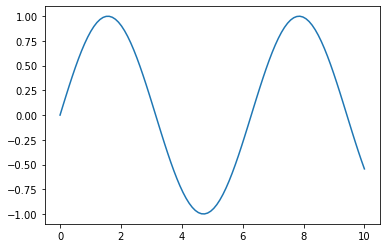

In [2]:
x_npy = np.linspace(0,10,100)
y_npy = np.sin(x_npy)

plt.plot(x_npy, y_npy)

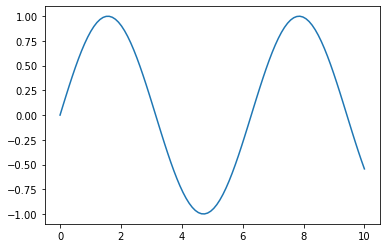

In [3]:
x_jnp = jnp.linspace(0,10,100)
y_jnp = jnp.sin(x_jnp)

plt.plot(x_jnp, y_jnp)

In [4]:
# JAX arrays are immutable
x = jnp.arange(10)
print(x)

x[3] = -1
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: ignored

In [5]:
# Solution
y = x.at[3].set(-1) # Allocating another object in memory
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[ 0  1  2 -1  4  5  6  7  8  9]


In [6]:
from jax import random

# Random numbers
key_ = random.PRNGKey(seed=0)

x = random.normal(key=key_, shape=(10,))

print(type(x))
print(x)

<class 'jaxlib.xla_extension.DeviceArray'>
[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


Notice how the results are on GPU already!

Hence, the same code runs everywhere.

In [7]:
from jax._src.api import block_until_ready
# Matrix Matrix Multiplication
size = 5000

x = random.normal(key=key_, shape=(size,size), dtype=jnp.float32)

%timeit jnp.dot(x, x.T).block_until_ready() 

The slowest run took 60.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 59.5 ms per loop


We can use numpy array directly as well.

In [8]:
x_np = np.random.normal(size=(size,size)).astype(np.float32)

%timeit jnp.dot(x_np, x.T).block_until_ready()

10 loops, best of 5: 74.2 ms per loop


The slow results are due to the fact that we are transfering data to GPU memory.

In [9]:
from jax import device_put
# Transfering manually to GPU Memory

%timeit x_np_device = device_put(x_np)

10 loops, best of 5: 17.3 ms per loop


In [12]:
x_np_device = device_put(x_np)

%timeit jnp.dot(x_np_device, x.T).block_until_ready()

10 loops, best of 5: 61.7 ms per loop


> `block_until_ready()` is required because of async dispatch in JAX!

## JAX Functions

JIT can be used to make a function run faster.

In [14]:
from jax import jit

def relu(x):
    return jnp.where(x > 0, x, 0)

key_ = random.PRNGKey(seed=1)
data = random.normal(key=key_, shape=(1000000,))

%timeit relu(data).block_until_ready()

# JIT compiling the function
jit_relu = jit(relu)

%timeit jit_relu(data).block_until_ready()

The slowest run took 233.04 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 747 µs per loop
The slowest run took 617.28 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 141 µs per loop


In [25]:
from jax import grad

def harmonics(x):
    return jnp.sin(2*x) + jnp.cos(4*x)

x_ = jnp.arange(3.)

d_harmonics = grad(harmonics)

print(d_harmonics(x_[0]))

2.0


In [27]:
def f(x):
    return x**2 + 3*x + 5

x_ = 1. # Note that input has to be float type

df_dx = grad(f)
d2f_dx2 = grad(df_dx)
d3f_dx3 = grad(d2f_dx2)

df_dx(x_), d2f_dx2(x_), d3f_dx3(x_)

(DeviceArray(5., dtype=float32, weak_type=True),
 DeviceArray(2., dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True))

In [31]:
def g(x,y):
    return x**2 + y**2 + 3*x + 4*y + 1

x_ = 1.
y_ = 2.

dg_dx = grad(g)
d2g_dx2 = grad(dg_dx)
d3g_dx3 = grad(d2g_dx2)

dg_dy = grad(g, argnums=1)
d2g_dy2 = grad(dg_dy, argnums=1)
d3g_dy3 = grad(d2g_dy2, argnums=1)

dg_dx(x_, y_), d2g_dx2(x_, y_), d3g_dx3(x_, y_), dg_dy(x_, y_), d2g_dy2(x_, y_), d3g_dy3(x_, y_)

(DeviceArray(5., dtype=float32, weak_type=True),
 DeviceArray(2., dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True),
 DeviceArray(8., dtype=float32, weak_type=True),
 DeviceArray(2., dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True))

Let a function be: $g(x,y)=x^2+y^2+3x+4y+1$, then

Jacobian is defined as: 

$$
J=\begin{pmatrix}
\frac{\partial g}{\partial x} \\ 
\frac{\partial g}{\partial y}
\end{pmatrix}
$$

Hessian is defined as:

$$
H=\begin{pmatrix}
\frac{\partial^2 g}{\partial x^2} & \frac{\partial^2 g}{\partial x \partial y} \\
\frac{\partial^2 g}{\partial y \partial x} & \frac{\partial^2 g}{\partial^2 y}
\end{pmatrix}
$$

In [38]:
from jax import jacfwd, jacrev

def jacobian(g):
    return jit(jacrev(g,argnums=(0,1)))

def hessian(g):
    dg = jacrev(g,argnums=(0,1))
    d2g = jacfwd(dg,argnums=(0,1))
    return jit(d2g)

jacobian(g)(x_,y_), hessian(g)(x_,y_)

((DeviceArray(5., dtype=float32, weak_type=True),
  DeviceArray(8., dtype=float32, weak_type=True)),
 ((DeviceArray(2., dtype=float32, weak_type=True),
   DeviceArray(0., dtype=float32, weak_type=True)),
  (DeviceArray(0., dtype=float32, weak_type=True),
   DeviceArray(2., dtype=float32, weak_type=True))))

In [49]:
from jax import vmap

@jit
def matvec(W,x):
    return jnp.dot(W,x)

W = random.normal(key=key_, shape=(20,100))

# Vectorising the matvec to compute results of 50 vectors in parallel
X = random.normal(key=key_, shape=(50,100))

vectorised_matvec = jit(vmap(matvec, in_axes=(None,0)))

%timeit vectorised_matvec(W,X).block_until_ready()

The slowest run took 501.03 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 107 µs per loop


In [46]:
@jit
def manual_matvec(X):
    return jnp.dot(W,X.T)

%timeit manual_matvec(X).block_until_ready()

The slowest run took 118.91 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 102 µs per loop


# **Advanced JAX**

In [50]:
from jax import lax

jnp.add(1, 2.2), lax.add(1, 2.2)

TypeError: ignored

In [51]:
x = jnp.array([1,2,3])
y = jnp.ones(10)

r1 = jnp.convolve(x,y)

r2 = lax.conv_general_dilated(
    x.reshape(1,1,3).astype(float),
    y.reshape(1,1,10),
    window_strides=(1,),
    padding=[(len(y)-1,len(y)-1)]
)

r1, r2

(DeviceArray([1., 3., 6., 6., 6., 6., 6., 6., 6., 6., 5., 3.], dtype=float32),
 DeviceArray([[[1., 3., 6., 6., 6., 6., 6., 6., 6., 6., 5., 3.]]], dtype=float32))